# Table of Contents

1. [Imports & Global Constants](#Imports-&-Global-Constants)
<br>&emsp;- 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
<br>

2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset)
<br>&emsp;- 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
<br>

3. [Define Dataset Class](#Define-Dataset-Class)
<br>&emsp;- 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
<br>

4. [Check Data Sample](#Check-Data-Sample)
<br>&emsp;- 제공된 데이터가 어떤 모습인지 확인합니다.
<br>

5. [Setup Dataloader](#Setup-Dataloader)
<br>&emsp;- 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
<br>

6. [Define Functions for Training](#Define-Functions-for-Training)
<br>&emsp;- 학습을 도와주는 함수들을 정의합니다.
<br>

7. [Training](#Training)
<br>&emsp;- 학습을 진행합니다.
<br>

8. [Inference](#Inference)
<br>&emsp;- 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
<br>

9. [Result Visualization](#Result-Visualization)
<br>&emsp;- 인퍼런스 결과를 확인해봅니다.
<br>

10. [To CSV](#To-CSV)
<br>&emsp;- 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [77]:
# 노트북 실행에 필요한 라이브러리를 설치합니다

# !pip install opencv-python-headless==4.10.0.84
# !pip install pandas==2.2.3
# !pip install -U scikit-learn==1.5.2
# !pip install albumentations==1.4.18
# !pip install matplotlib==3.9.2

In [78]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

In [79]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "/data/ephemeral/home/data/train/DCM"
LABEL_ROOT = "/data/ephemeral/home/data/train/outputs_json"

In [80]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [81]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [82]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [ ]:
BATCH_SIZE = 8
LR = 1e-4
RANDOM_SEED = 21

NUM_EPOCHS = 5
VAL_EVERY = 5

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [84]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [85]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [86]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [87]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [88]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [89]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [90]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [91]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [92]:
tf = A.Resize(512, 512)

In [93]:
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)

In [94]:
image, label = train_dataset[0]

In [95]:
print(image.shape, label.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


In [96]:
len(train_dataset)

640

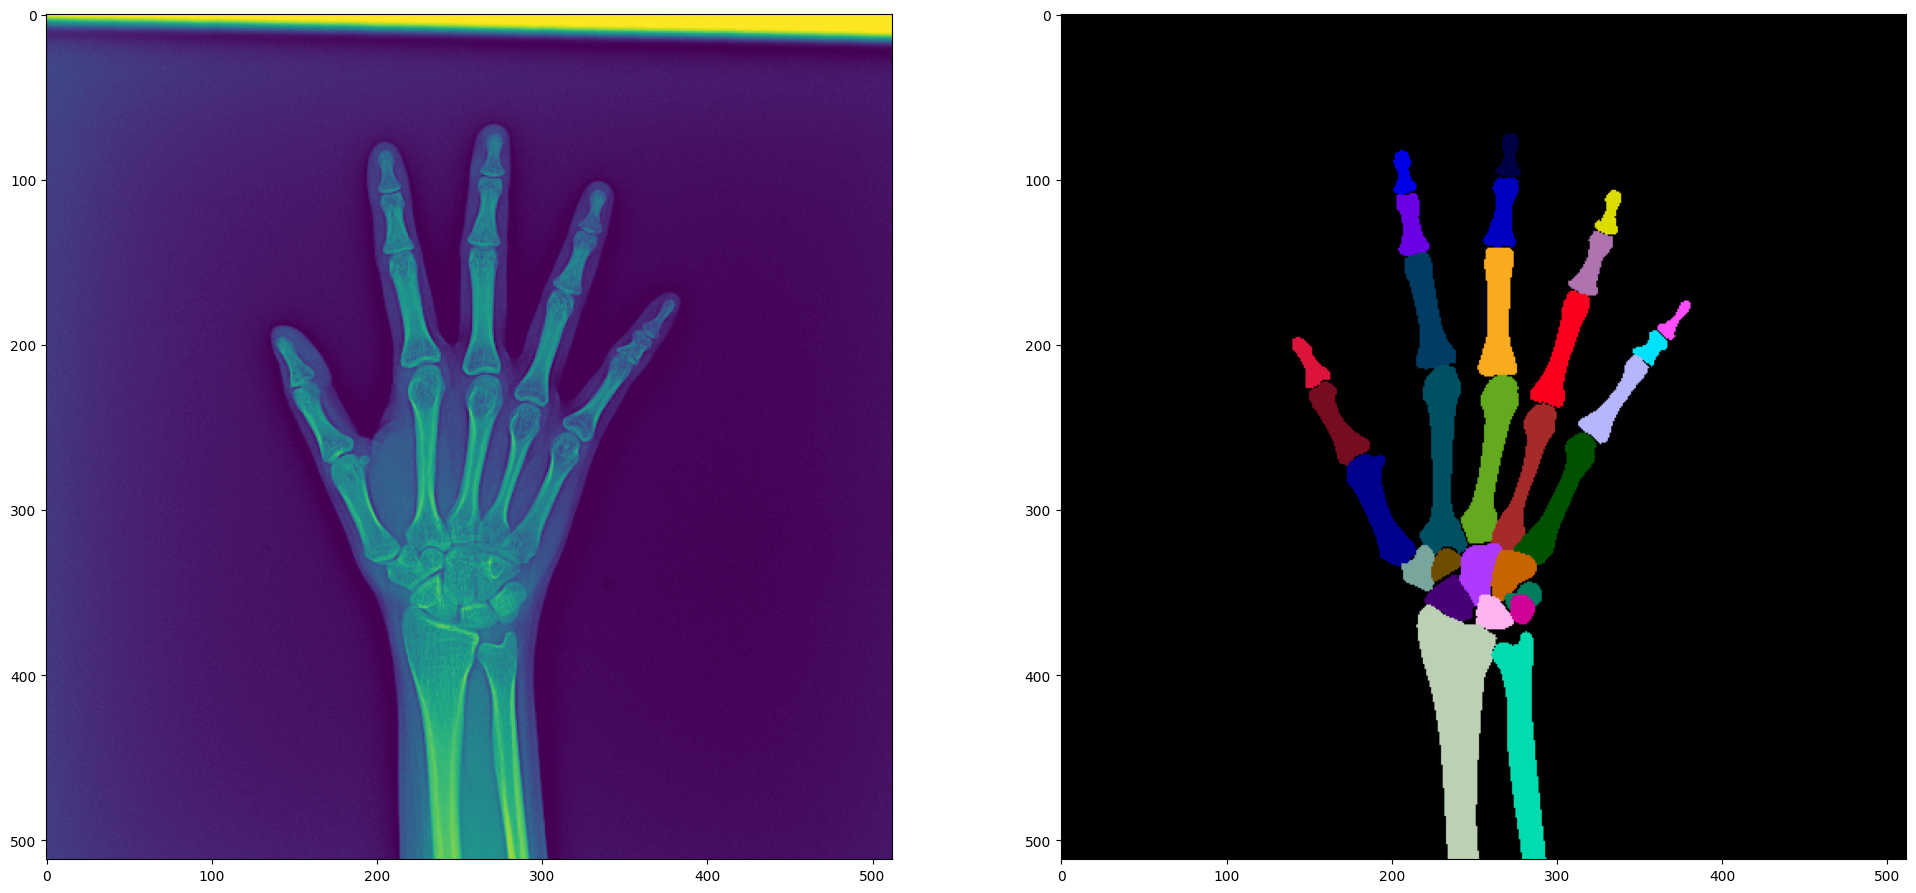

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].imshow(label2rgb(label))

plt.show()

# Setup Dataloader

In [98]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

# 주의: validation data는 이미지 크기가 크기 때문에 `num_wokers`는 커지면 메모리 에러가 발생할 수 있습니다.
valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=8,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

# Define Functions for Training

In [99]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [100]:
def save_model(model, file_name='fcn_resnet50_best_model.pt'):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [101]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [102]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.eval()

    dices = []
    with torch.no_grad():
        n_class = len(CLASSES)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()         
            model = model.cuda()
            
            outputs = model(images)['out']
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # gt와 prediction의 크기가 다른 경우 prediction을 gt에 맞춰 interpolation 합니다.
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            loss = criterion(outputs, masks)
            total_loss += loss
            cnt += 1
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu()
            masks = masks.detach().cpu()
            
            dice = dice_coef(outputs, masks)
            dices.append(dice)
                
    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)
    
    avg_dice = torch.mean(dices_per_class).item()
    
    return avg_dice

In [103]:
def train(model, data_loader, val_loader, criterion, optimizer):
    print(f'Start training..')
    
    n_class = len(CLASSES)
    best_dice = 0.
    
    for epoch in range(NUM_EPOCHS):
        model.train()

        for step, (images, masks) in enumerate(data_loader):            
            # gpu 연산을 위해 device 할당합니다.
            images, masks = images.cuda(), masks.cuda()
            model = model.cuda()
            
            outputs = model(images)['out']
            
            # loss를 계산합니다.
            loss = criterion(outputs, masks)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # step 주기에 따라 loss를 출력합니다.
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(train_loader)}], '
                    f'Loss: {round(loss.item(),4)}'
                )
             
        # validation 주기에 따라 loss를 출력하고 best model을 저장합니다.
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            
            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)

# Training

In [104]:
model = models.segmentation.fcn_resnet50(pretrained=True)

# output class 개수를 dataset에 맞도록 수정합니다.
model.classifier[4] = nn.Conv2d(512, len(CLASSES), kernel_size=1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [105]:
# Loss function을 정의합니다.
criterion = nn.BCEWithLogitsLoss()

# Optimizer를 정의합니다.
optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)

In [106]:
# 시드를 설정합니다.
set_seed()

In [107]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training..
2024-11-11 10:25:33 | Epoch [1/25], Step [25/80], Loss: 0.5416
2024-11-11 10:26:00 | Epoch [1/25], Step [50/80], Loss: 0.4473
2024-11-11 10:26:27 | Epoch [1/25], Step [75/80], Loss: 0.3589
2024-11-11 10:27:12 | Epoch [2/25], Step [25/80], Loss: 0.2706
2024-11-11 10:27:41 | Epoch [2/25], Step [50/80], Loss: 0.2141
2024-11-11 10:28:07 | Epoch [2/25], Step [75/80], Loss: 0.1718
2024-11-11 10:28:49 | Epoch [3/25], Step [25/80], Loss: 0.1351
2024-11-11 10:29:16 | Epoch [3/25], Step [50/80], Loss: 0.1124
2024-11-11 10:29:45 | Epoch [3/25], Step [75/80], Loss: 0.0954
2024-11-11 10:30:26 | Epoch [4/25], Step [25/80], Loss: 0.0794
2024-11-11 10:30:55 | Epoch [4/25], Step [50/80], Loss: 0.0699
2024-11-11 10:31:22 | Epoch [4/25], Step [75/80], Loss: 0.0611
2024-11-11 10:32:04 | Epoch [5/25], Step [25/80], Loss: 0.0525
2024-11-11 10:32:32 | Epoch [5/25], Step [50/80], Loss: 0.0474
2024-11-11 10:33:00 | Epoch [5/25], Step [75/80], Loss: 0.0431
Start validation # 5


  0%|          | 0/20 [00:08<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.62 GiB. GPU 0 has a total capacty of 31.74 GiB of which 3.53 GiB is free. Process 3519779 has 28.20 GiB memory in use. Of the allocated memory 19.15 GiB is allocated by PyTorch, and 8.66 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Inference

In [ ]:
model = torch.load(os.path.join(SAVED_DIR, "fcn_resnet50_best_model.pt"))

In [ ]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "/data/ephemeral/home/data/test/DCM"

In [ ]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [ ]:
len(pngs)

288

In [ ]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [ ]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)  
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [ ]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)['out']
            
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [ ]:
tf = A.Resize(512, 512)

In [ ]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [ ]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [ ]:
rles, filename_and_class = test(model, test_loader)

100%|██████████| 144/144 [03:00<00:00,  1.25s/it]


# Result Visualization

In [ ]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [ ]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [ ]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

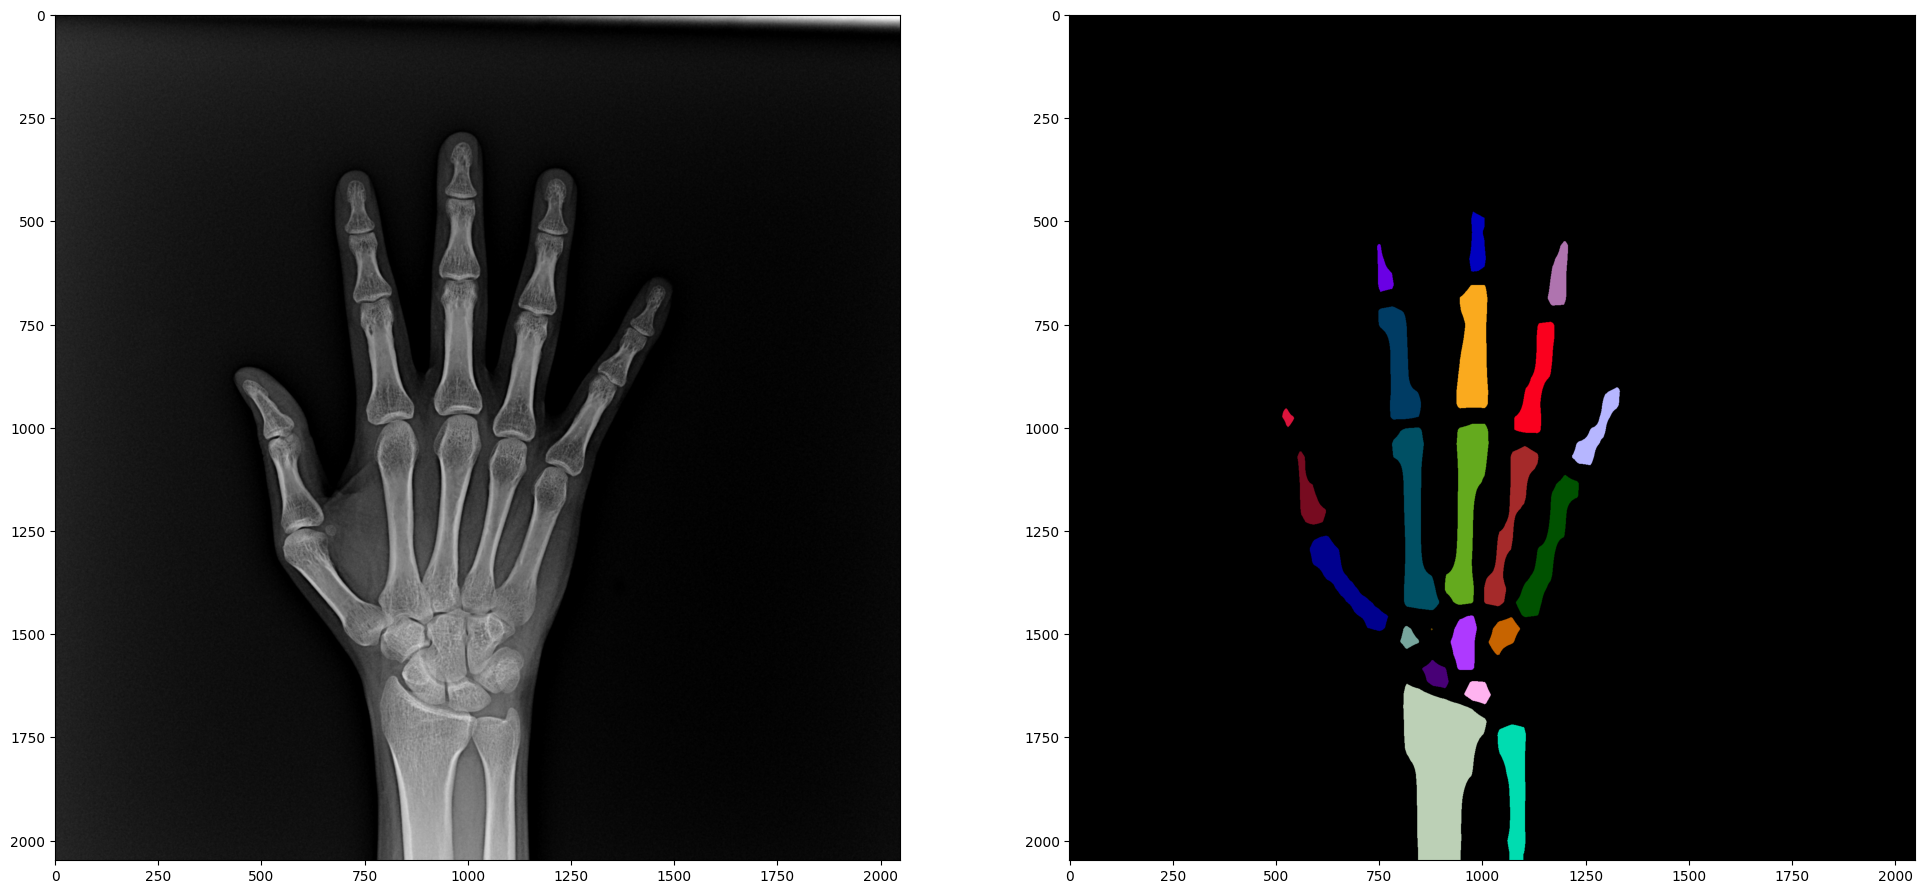

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [ ]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [ ]:
image_name = [os.path.basename(f) for f in filename]

In [ ]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [ ]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1954318 1 1956365 3 1958412 5 1960459 7 196250...
1,image1661319116107.png,finger-2,2169391 5 2171439 5 2173486 7 2175534 8 217758...
2,image1661319116107.png,finger-3,2587244 6 2589288 12 2591331 19 2593376 23 259...
3,image1661319116107.png,finger-4,
4,image1661319116107.png,finger-5,1141486 4 1143533 6 1145580 7 1147628 8 114967...
5,image1661319116107.png,finger-6,1450764 6 1452807 14 1454849 22 1456892 29 145...
6,image1661319116107.png,finger-7,2050885 12 2052919 27 2054959 37 2057005 39 20...
7,image1661319116107.png,finger-8,
8,image1661319116107.png,finger-9,979923 1 981971 2 984018 5 986066 7 988114 8 9...
9,image1661319116107.png,finger-10,1344463 32 1346509 35 1348556 37 1350604 37 13...


In [ ]:
df.to_csv("output.csv", index=False)